In [6]:
!pip install numpy==1.21.0

In [7]:
!pip install Flask==2.0.3
!pip install Jinja2==3.0.3

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import joblib
from imblearn.over_sampling import SMOTE


# Data Acquisition: Load data
data = pd.read_csv('customer_churn_data1.csv')

# Data Processing:
#Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
# Normalize numerical features
numerical_features = ['age', 'tenure', 'monthly_charges', 'call_frequency', 'data_usage', 'internet_usage']
scaler = StandardScaler()
data_imputed[numerical_features] = scaler.fit_transform(data_imputed[numerical_features])


# Feature engineering
data['CLTV'] = data['tenure'] * data['monthly_charges']
data['ARPU'] = data['monthly_charges']
data['call_data_ratio'] = data['call_frequency'] / (data['call_frequency'] + data['data_usage'])

# Identify categorical and numerical features
categorical_features = ['gender', 'location', 'plan_type', 'payment_methods', 'issue_types']
numerical_features = ['age', 'tenure', 'monthly_charges', 'call_frequency', 'data_usage', 'internet_usage', 'CLTV', 'ARPU', 'call_data_ratio']


# Separate the preprocessing for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Prepare data
X = data.drop(columns=['churn'])
y = data['churn']

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Import necessary libraries
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder:
label_encoder = LabelEncoder()

# Iterate over columns and encode string columns, to deal with any string in the training data
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = label_encoder.fit_transform(X_train[col])
        X_val[col] = label_encoder.transform(X_val[col])
        X_test[col] = label_encoder.transform(X_test[col])
        
#hadling Imbalance
smote = SMOTE()
X_res,y_res = smote.fit_resample(X_train,y_train)

# Define models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_res[y_res == 0]) / len(y_res[y_res == 1]))
}

# Train and evaluate models
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_res, y_res)
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred)
    }

# Display results
for name, metrics in results.items():
    print(f"Performance of {name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()


Performance of Logistic Regression:
Accuracy: 0.5933333333333334
Precision: 0.17391304347826086
Recall: 0.25806451612903225
F1-score: 0.2077922077922078
AUC-ROC: 0.46936839251829765

Performance of Random Forest:
Accuracy: 0.7266666666666667
Precision: 0.25
Recall: 0.16129032258064516
F1-score: 0.19607843137254902
AUC-ROC: 0.517619951206289

Performance of XGBoost:
Accuracy: 0.6866666666666666
Precision: 0.21428571428571427
Recall: 0.1935483870967742
F1-score: 0.20338983050847456
AUC-ROC: 0.5043372187584712



### Shap Analysis for the best model (Random Forest) and model performance comparison

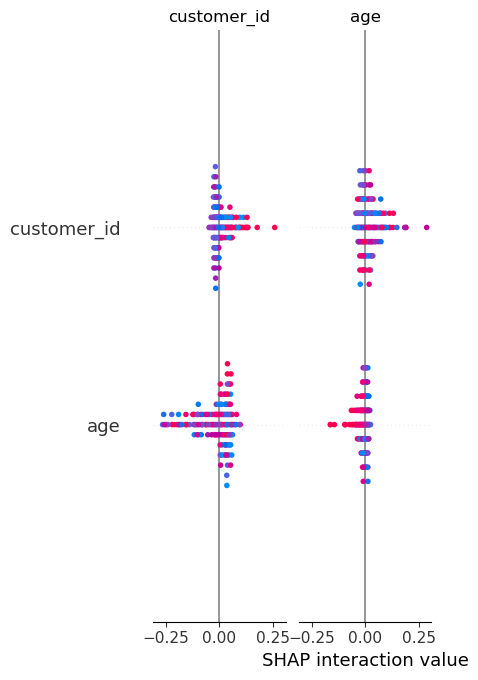

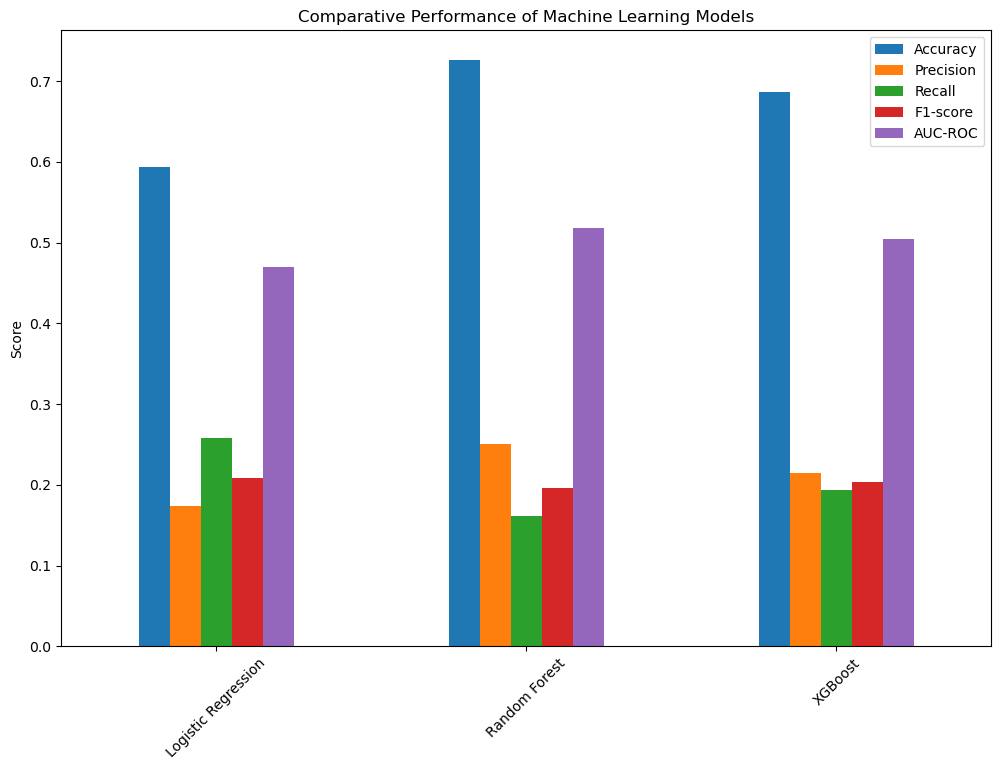

In [9]:
#SHAP Analysis for the best model (For Random Fores)
best_model_name = 'Random Forest'
best_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[best_model_name])])
best_model_pipeline.fit(X_res, y_res)

# Transform the test set using the preprocessor
X_test_transformed = best_model_pipeline['preprocessor'].transform(X_test)

# Generate SHAP values
explainer = shap.Explainer(best_model_pipeline['model'])
shap_values = explainer(X_test_transformed)

# Visualize SHAP values
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=X_test.columns)

# Comparative performance plot
performance_df = pd.DataFrame(results).T

# Plot the performance metrics
fig, ax = plt.subplots(figsize=(12, 8))
performance_df.plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.title('Comparative Performance of Machine Learning Models')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

Summary and Recommendation

Summary

Best Model: Based on the current metrics, Random Forest and XGBoost have the same accuracy but very low precision, recall, F1-score, and AUC-ROC, indicating that class imbalance handling needs improvement.

Recommendations: 

Improve class imbalance handling, perform further feature engineering, conduct extensive hyperparameter tuning, and consider model ensemble methods

Shap Interpretation:
Important features affecting the output of the prediction are Customer ID and Age

For age: means age affects customer churn negatively. The higher the age the higher the likelihood of churning
For Customer ID: it could be due to data leakage and hence have to be removed during feature Engineering

# Deployment Considerations
1. Save the classifier as a pickle file
2. Save this file as a Python executable file
3. Create A requirement file
4. Upload the data on the deploying platform
5. For Integration into Existing Systems - Use either fast API or AWS API Gateway
6. For real-time processing, deploy the model as a web service using Flask Streamlit, Heroku or AWS EC2 instance
7. For batch processing, schedule regular predictions using an ETL pipeline.

# Bonus: Handling Imbalanced Datasets
we would pick one of the models

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define Random Forest with class weight adjustment
rf = RandomForestClassifier(class_weight='balanced')

# Train the model
rf.fit(X_res, y_res)

# Predict and evaluate on the test set
y_pred = rf.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.74
Precision: 0.25
Recall: 0.12903225806451613
F1-score: 0.1702127659574468
AUC-ROC: 0.5140959609650312

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       119
           1       0.25      0.13      0.17        31

    accuracy                           0.74       150
   macro avg       0.52      0.51      0.51       150
weighted avg       0.69      0.74      0.71       150



# Extras: Saving models as Pickel file for realtime prediction

In [13]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Create a pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Save the model to a pickle file
joblib.dump(model_pipeline, 'random_forest_model.pkl')

print("Model saved as random_forest_model.pkl")


Model saved as random_forest_model.pkl
